In [1]:
# Improved Renewable Energy & Load Forecasting Pipeline
# Each section below is annotated to explain its purpose and logic.

# 1. Imports and Settings
# -----------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # for additional visualizations

# scikit-learn utilities for pipelines, preprocessing, model selection, evaluation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# statsmodels for time-series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# 2. Load and Clean Data
# ----------------------
df = pd.read_csv(
    "C:/Users/Admin/Downloads/maharashtra_2024_daily_energy_forecasting_dataset.csv",
    encoding="cp1252"
)

# Standardize column names to avoid duplicates/typos
df.rename(columns={
    'Solar Radiation(W/m²)': 'Solar Radiation',
    'Solar Radiation(W/mA²)': 'Solar Radiation',
    'Wind Speed(km/h)': 'Wind Speed',
    'Wind Speed (km/h)': 'Wind Speed',
    'Temperature(C)': 'Temperature (°C)',
    'Humidity(%)': 'Humidity (%)',
    'Rainfall(mm)': 'Rainfall (mm)',
    'Cloud Cover(%)': 'Cloud Cover (%)',
}, inplace=True)

# Define numeric columns for imputation
# These will be used to fill missing values
target_cols = [
    'Solar Power (MW)', 'Wind Power (MW)', 'Hydro Power (MW)',
    'Electric Load (MW)', 'Solar Radiation (W/m²)', 'Wind Speed (m/s)',
    'Temperature (Â°C)', 'Humidity (%)', 'Rainfall (mm)', 'Cloud Cover (%)'
]

# Parse 'Date' into datetime and sort chronologically
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Admin/Downloads/maharashtra_2024_daily_energy_forecasting_dataset.csv'

In [ ]:
# 3. Feature Engineering
# ----------------------
# Extract time-based features
df['Month']   = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.dayofweek

In [ ]:
print(df.head())

        Date Day of Week  Season        City    Load Type  Temperature (Â°C)  \
0 2024-01-01      Monday  Winter      Nashik        Mixed          29.951667   
1 2024-01-02     Tuesday  Winter  Aurangabad        Mixed          29.735000   
2 2024-01-03   Wednesday  Winter        Pune  Residential          28.551250   
3 2024-01-04    Thursday  Winter      Nagpur   Industrial          30.765417   
4 2024-01-05      Friday  Winter      Nashik  Residential          29.030417   

   Humidity (%)  Rainfall (mm)  Cloud Cover (%)  Wind Speed (m/s)  \
0          59.8            2.1             38.7          5.521667   
1          61.3            8.8             35.2          5.666667   
2          82.4            4.0             43.4          6.043750   
3          70.1            3.4             26.9          6.080417   
4          51.4            5.3             69.9          5.771667   

   Solar Radiation (W/m²)  Wind Power (MW)  Solar Power (MW)  \
0                 2963.66           782.

In [ ]:
# 4. Imputation
# -------------
# Define numeric columns and fill missing values using linear interpolation over the DataFrame index
# (since the index is not a DatetimeIndex, `method='linear'` is appropriate)
df[target_cols] = df[target_cols].interpolate(method='linear')
# Backfill any remaining NaNs at the start of the series
df[target_cols] = df[target_cols].bfill()

In [ ]:
# 5. Lag & Rolling Features Lag & Rolling Features
# -------------------------
# Compute total renewable generation
df['TotalRenewable'] = (
    df['Solar Power (MW)'] +
    df['Wind Power (MW)'] +
    df['Hydro Power (MW)']
)
# Create lag features to capture temporal dependence
df['TotalRenewable_lag_1'] = df['TotalRenewable'].shift(1)
df['TotalRenewable_lag_7'] = df['TotalRenewable'].shift(7)
# Load lag and rolling mean
df['ElectricLoad_lag_1'] = df['Electric Load (MW)'].shift(1)
df['Load_roll_7d']      = df['Electric Load (MW)'].rolling(window=7).mean()
# Drop rows with NaNs from lag/rolling
df.dropna(subset=[
    'TotalRenewable_lag_1', 'TotalRenewable_lag_7',
    'ElectricLoad_lag_1', 'Load_roll_7d'
], inplace=True)

In [ ]:
# 6. Define Features List
# -----------------------
features = [
    'Temperature (Â°C)', 'Humidity (%)', 'Rainfall (mm)',
    'Wind Speed (m/s)', 'Solar Radiation (W/m²)', 'Cloud Cover (%)',
    'Month', 'Weekday',
    'TotalRenewable_lag_1', 'TotalRenewable_lag_7',
    'ElectricLoad_lag_1', 'Load_roll_7d'
]

In [ ]:
# 7. Train/Test Split (Time-Based)
# --------------------------------
# Use the first 80% of data for training
data_len = len(df)
train_end = int(data_len * 0.8)
train_df = df.iloc[:train_end]
test_df  = df.iloc[train_end:]

X_train   = train_df[features]
y_train_R = train_df['TotalRenewable']
y_train_L = train_df['Electric Load (MW)']

X_test    = test_df[features]
y_test_R  = test_df['TotalRenewable']
y_test_L  = test_df['Electric Load (MW)']

In [ ]:
# 8. Pipeline & Hyperparameter Search
# ----------------------------------
# Preprocessing: KNN imputation + standard scaling
preprocessor = ColumnTransformer([
    ('impute', KNNImputer(n_neighbors=5), features),
    ('scale', StandardScaler(), features)
])
pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])
# Hyperparameter distribution for Random Forest
tree_params = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_leaf': [1, 2, 4]
}
cv_split = TimeSeriesSplit(n_splits=5)
search = RandomizedSearchCV(
    pipeline, tree_params,
    n_iter=10, cv=cv_split,
    scoring='neg_root_mean_squared_error',
    random_state=42, n_jobs=-1, verbose=1
)

In [ ]:
# 9. Fit & Evaluate Renewable Model
# ---------------------------------
search.fit(X_train, y_train_R)
best_R = search.best_estimator_
y_pred_R = best_R.predict(X_test)
print("Renewable R²:", r2_score(y_test_R, y_pred_R))
print("Renewable RMSE:", np.sqrt(mean_squared_error(y_test_R, y_pred_R)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Renewable R²: 0.9319974215311986
Renewable RMSE: 19.397568236202595


In [ ]:
# 10. Fit & Evaluate Load Model
# -----------------------------
search.fit(X_train, y_train_L)
best_L = search.best_estimator_
y_pred_L = best_L.predict(X_test)
print("Load R²:", r2_score(y_test_L, y_pred_L))
print("Load RMSE:", np.sqrt(mean_squared_error(y_test_L, y_pred_L)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Load R²: 0.8402556849423313
Load RMSE: 33.1624038520576


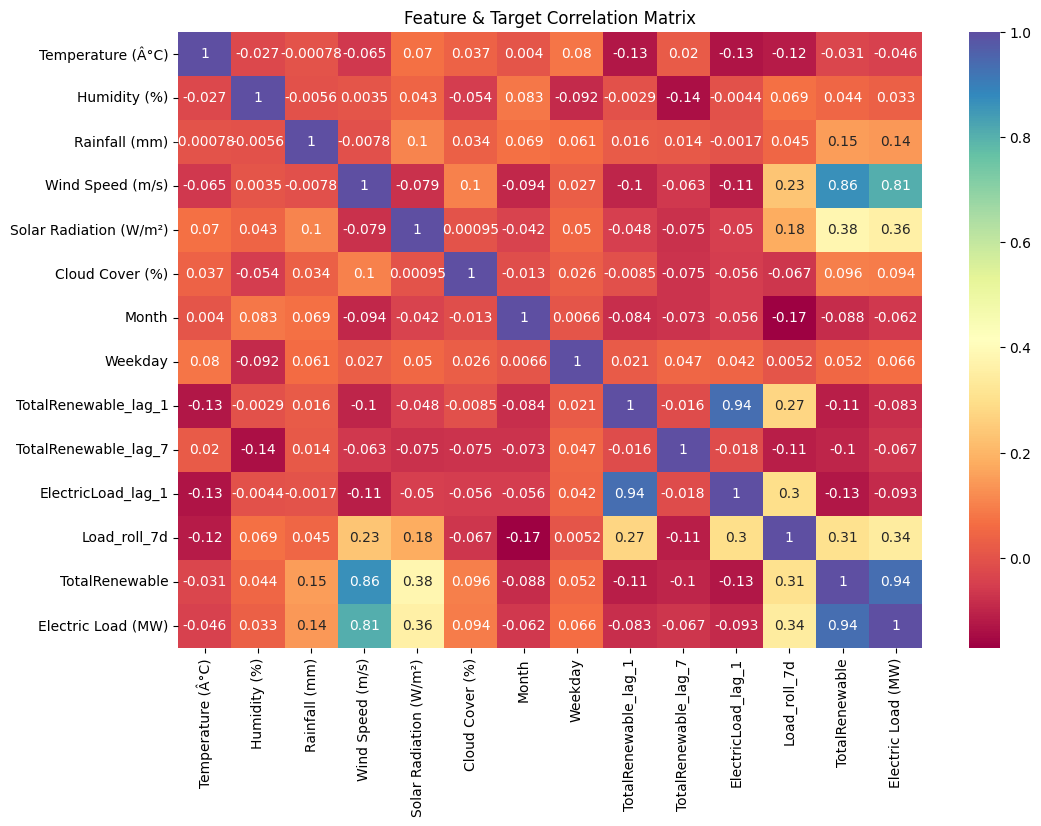

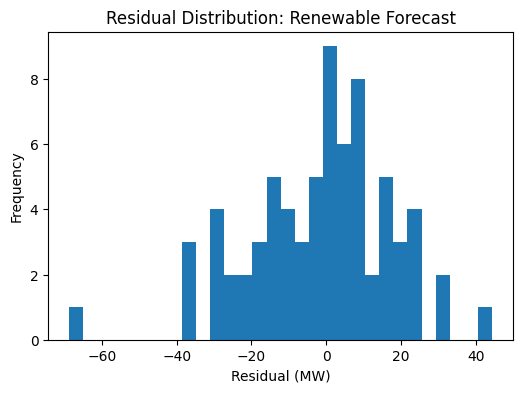

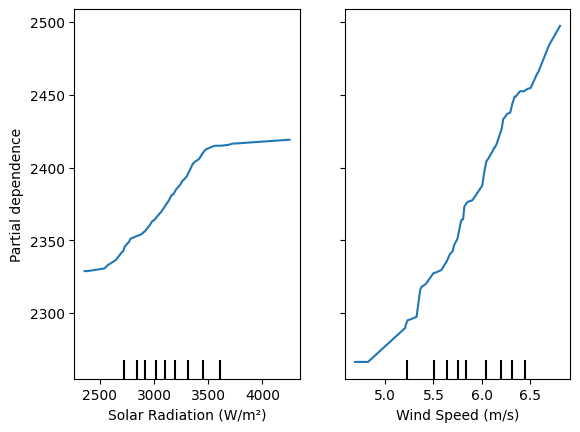

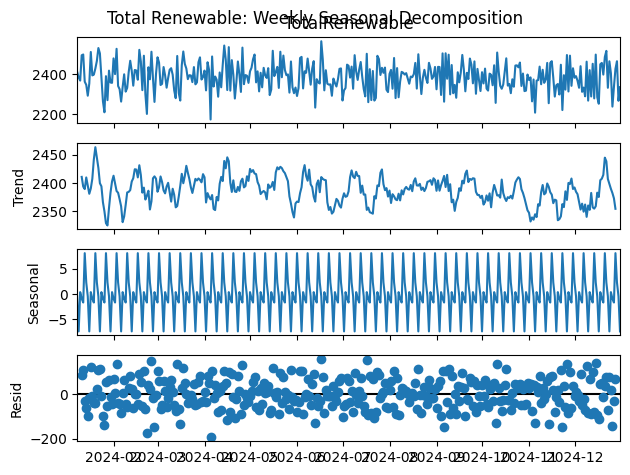

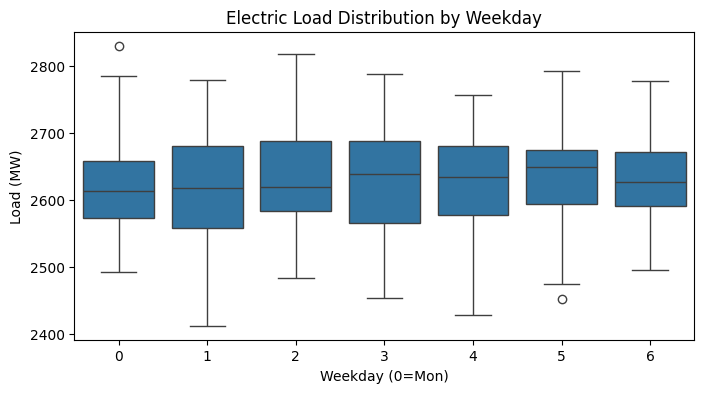

In [ ]:
# 11. Visualization Enhancements
# ------------------------------
# 11.1 Correlation Heatmap among features + targets
disp_cols = features + ['TotalRenewable', 'Electric Load (MW)']
plt.figure(figsize=(12,8))
sns.heatmap(df[disp_cols].corr(), annot=True, cmap='Spectral')
plt.title('Feature & Target Correlation Matrix')
plt.show()

# 11.2 Residual Histogram (Renewable)
res_R = y_test_R - y_pred_R
plt.figure(figsize=(6,4))
plt.hist(res_R, bins=30)
plt.title('Residual Distribution: Renewable Forecast')
plt.xlabel('Residual (MW)')
plt.ylabel('Frequency')
plt.show()

# 11.3 Partial Dependence for top 2 features (Renewable)
perm_R = permutation_importance(best_R, X_test, y_test_R, n_repeats=5, random_state=42)
top2 = perm_R.importances_mean.argsort()[-2:]
pd_features = [features[i] for i in top2]
PartialDependenceDisplay.from_estimator(best_R, X_test, features=pd_features)
plt.show()

# 11.4 Seasonal Decomposition of Total Renewable
# Use a weekly period (7 days) since we have fewer than 2 full annual cycles
series = df.set_index('Date')['TotalRenewable']
if len(series) >= 14:
    deco = seasonal_decompose(series, model='additive', period=7)
    deco.plot()
    plt.suptitle('Total Renewable: Weekly Seasonal Decomposition')
    plt.show()
else:
    print(f"Too few observations ({len(series)}) for seasonal decomposition; need at least 2·period.")

# 11.5 Boxplot of Electric Load by Weekday Boxplot of Electric Load by Weekday
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Weekday'], y=df['Electric Load (MW)'])
plt.title('Electric Load Distribution by Weekday')
plt.xlabel('Weekday (0=Mon)')
plt.ylabel('Load (MW)')
plt.show()

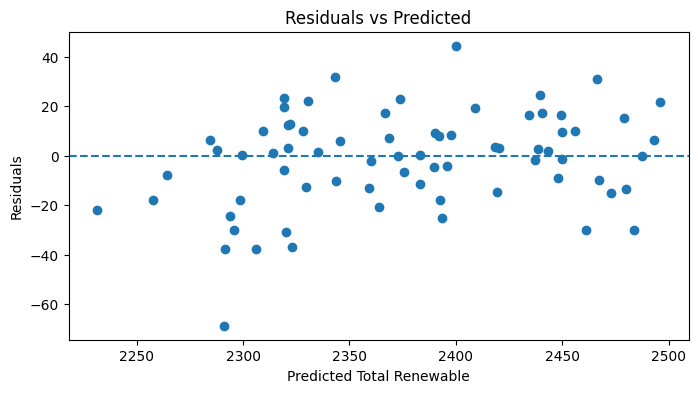

In [ ]:
# 13. Residual Analysis
residuals = y_test_R - y_pred_R
plt.figure(figsize=(8,4))
plt.scatter(y_pred_R, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted Total Renewable')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

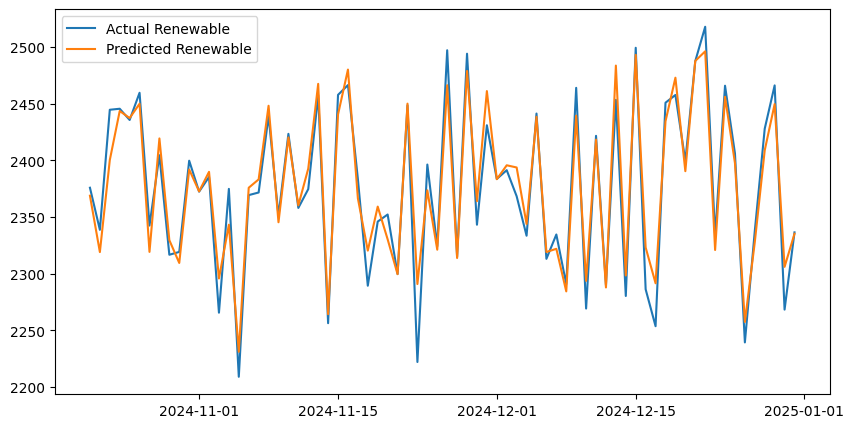

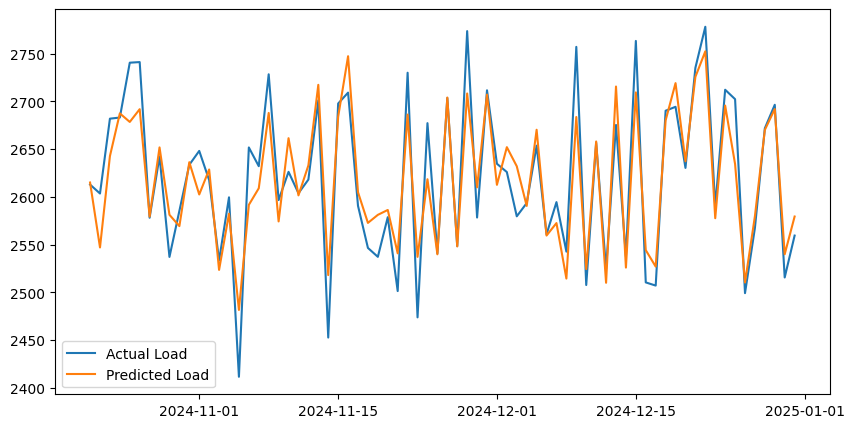

In [ ]:
# 15. Plot Time-Series Predictions vs Actual
plt.figure(figsize=(10,5))
plt.plot(test_df['Date'], y_test_R, label='Actual Renewable')
plt.plot(test_df['Date'], y_pred_R, label='Predicted Renewable')
plt.legend(); plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_df['Date'], y_test_L, label='Actual Load')
plt.plot(test_df['Date'], y_pred_L, label='Predicted Load')
plt.legend(); plt.show()